# Chapter 3: Classification

## Setup

In [22]:
# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn

assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Acquire and explore the data

We will be using the MNIST dataset, to classify digit images.

Let's fetch the MNIST dataset first. By default it will be stored in `$HOME/scikit_learn_data`

In [23]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure.
- `DESCR` describe the dataset
- `data` contains an array with one row per instance and one column per feature
- `target` key contains array with the labels

In [24]:
import pandas as pd

pd.DataFrame(mnist["data"]).head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Each row represents one instance, and each column represents one feature

In [25]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape, sep="\n")

(70000, 784)
(70000,)


Each image is 28 x 28 pixels, thus it contains 784 features, where each feature represents one pixel, from 0 to 255 (white tho black)

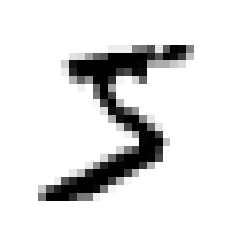

In [26]:
some_digit = X[0]

# let's reshape the vector to a 28x28 array
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [27]:
y[0]

'5'

The label is actually a `string` so we will need to cast `y` to an `integer`

In [28]:
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

## Set aside a test set

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (10,000 images).

The dataset is also already shuffled

In [29]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier

Let's start by creating a model that identifies only one digit. Whethere a digit is 5 or not 5. 

In [30]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

We will start with the _Stochastic Gradient Descent_ classifier

In [31]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

We set the random state to a value to get reproducible results

In [32]:
sgd_clf.predict([some_digit])

array([ True])

This worked correctly, although it is just one digit

## Performance Measures

Evaluating a classifier is often more difficult than evaluating a regressor (like we did on chapter 2).

We can start evaluating the model with cross-validation

***
### Implementing cross-validation with more control

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # create a clone of the classifier
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # Print indices of each fold to understand what is happening behind
    print(
        "New Fold",
        "Train Index:",
        train_index,
        "Test Index:",
        test_index,
        sep="\n",
    )

    # continue with the code as in the book
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred), end=("\n" * 2))

New Fold
Train Index:
[    1     3     4 ... 59994 59996 59998]
Test Index:
[    0     2     6 ... 59995 59997 59999]
0.9669

New Fold
Train Index:
[    0     2     3 ... 59997 59998 59999]
Test Index:
[    1    10    11 ... 59988 59989 59991]
0.91625

New Fold
Train Index:
[    0     1     2 ... 59995 59997 59999]
Test Index:
[    3     4     5 ... 59994 59996 59998]
0.96785



***

Lets go back to using `cross_val_score()` included in scikit-learn

In [34]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Over 93% in each fold is pretty good, but it doesn't mean much really...

To prove this, we will make a **really** dumb classifier, it will classify all images as "not a 5"

In practice, you will have an array of predictions which are all set to `False`. The labels will match the `y_train_5` which contains an array of `False` if not a 5, `True` if a 5. The classifier will fail in all images that are 5 - classifying them as `False` when in fact they are `True`

In [35]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [36]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

You're getting over 90% accuracy in a clearly flawed model. 

Only about 10% of the images are 5s, so if you always guess that an image is *not* a 5, you will be right about 90% of the time.

**Important takeaway**: Accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed datasets (some classes are more frequent than others)

### Confusion Matrix

Count number of instances of class A that are counted as class B

We will need a set of predictions so that they can be compared to the actual targets. For this we can use the `cross_val_predict()` function

Even though we will use folds, training the models 3 times (60,000 instances x 3 times), we will receive an array of m = 60,000 predictions (as if the model was trained once). This is because

> The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised). [Source](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

In [37]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now we are going to use the confusion matrix

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In the array above, each `row` represents an actual class, while each `column` represents a predicted class. 

There are three important metrics that we can get from the confusion matrix:

1. Precision

$$\text{precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$$

$\text{TP}$ is the number of true positives, and $\text{FP}$ is the number of false positives

2. Recall

$$\text{recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}$$

$\text{TP}$ is the number of true positives, and $\text{FN}$ is the number of false negatives

In [39]:
from sklearn.metrics import precision_score, recall_score


precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [40]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called $F_1 \text{score}$. The $F_1$ score is the harmonic mean of precision and recall. The classifier will only get a high $F_1$ score if both recall and precision are high

$$
F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 * \frac{\text{precision} * \text{recall}}{\text{precision} + \text{recall}} = \frac{\text{TP}}{TP+\frac{\text{FN}+\text{FP}}{2}}
$$

In [41]:
from sklearn.metrics import f1_score

print(f"F1 Score: {f1_score(y_train_5, y_train_pred)}")

F1 Score: 0.7325171197343846


### Precision/Recall Trade-Off

Classifiers like `SGDClassifier` use a threshold. Changing the value of the threshold increase recall(precision) and decreases precision(recall).

You can't set a threshold in Scikit-learn to make a prediction, but you can access the decision scores that it uses to make predicitions. 

Using the schores, you can use any threshold to make predictions:

In [42]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [43]:
threshold = 0
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [44]:
# if set threshold to 8,000
threshold = 8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

To decide which threshold to use, we can use `cross_val_predoct()` to get the scores of al linstances in the training set, but this time sprecify that we want the decision scores

In [45]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

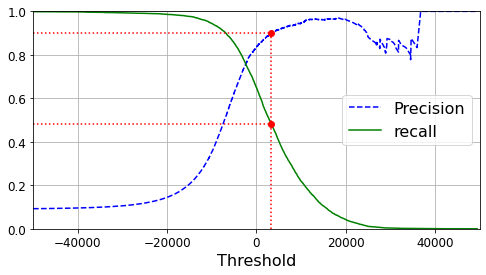

In [46]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.legend(loc="center right", fontsize=16)  # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)         # Not shown
    plt.grid(True)                               # Not shown
    plt.axis([-50000, 50000, 0, 1])              # Not shown


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                    # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                   # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                  # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                               # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                               # Not shown
plt.show()

### The ROC Curve

Similar to the precision/recall curve, but instead of plotting precision vs. recall, the ROC curve plots the True Positive Rate (i.e. Recall) against the _false positive rate_

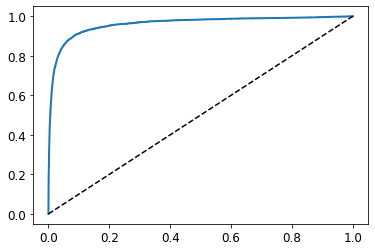

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')


plot_roc_curve(fpr, tpr)
plt.show()

As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve

## Multiclass Classification

Multiclass classifiers can distinguish between more than two classes, in contrast with binary classifiers with can only distinguis 2 classes.

One way to create a system that can classify 10 classes is to train 10 binary classifiers, one for each digit. Then when we want to classify an image, you get the decision score from each classifier for the image and you select the class whose classifier outputs the highest score. This is called **one-versus-the-rest** strategy

Another strategy is to train a binary classifier for every pair of digits. 0-1, 0-2, 1-2, etc...If there are $N$ classes, you need to train $\frac{N*(N-1)}{2}$ classifiers.When you want to classify an image, you have to run the image through all the classifiers and see which class wins the most duels. This is called a **one-versus-one** strategy.The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Scikit-Learn detects when you try to use a binary classification algorithm for a multi-class classification task, and it automatically runs OvR or OvO, depending on the algorithm. 

In [48]:
# Train a multiclass classification using a Support Vector Machine

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

If you call the `decision_function()` method, you will see that it returns 10 scores per instance. That's one score per class:

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [50]:
print(np.argmax(some_digit_scores),
      svm_clf.classes_,
      svm_clf.classes_[5],
      sep="\n"
     )

5
[0 1 2 3 4 5 6 7 8 9]
5


We can force scikit-learn to use one-versus-one or one-vesus-the-rest, by passing `OneVsOneClassifier` or `OneVsRestClassifier`. Simply create an instance and pass a classifier to its constructor.

In [51]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

We can train an `SGDClassifier` easily as well. In facto, SGD classifiers can directly classify instances into multiple classes, without needing to run OvR or OvO

In [52]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This was predicted as a 3...In the book it shows it should be predicted correctly as a 5, but if we go to the jupyter notebook source it is also being predicted as a 3. [Source](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)

This is because we are using version `0.24.1` instead of version `0.20.0`

In [53]:
sklearn.__version__

'0.24.1'

Now we evaluate `SGDClassifier` accuracy

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Not bad, but we can do better by scaling the inputs

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

Now we look at the type of errors the model is making

In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Let's look at an image representation of the confusion matrix, using mpl's `matshow()`

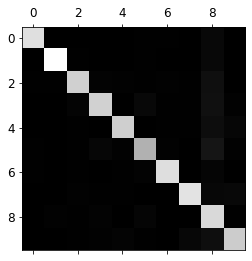

In [57]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The diagonal shows us that most of the images are being classified correctly. 

Let's focus on the errors by first calculating the error rates (as %) and then plotting the matrix

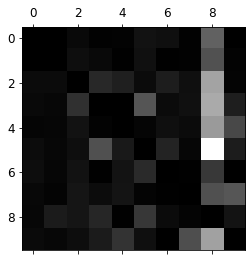

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill the diagonals with zeros to keep only the errors, and plot the results
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray) 
plt.show()

The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical.

## Multilabel Classification

In some cases you want to get multiple classes for a single instance. 

In [59]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [60]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605